## Movielens

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [2]:
path='data/ml-latest-small/'

We're working with the movielens data, which contains one rating per row, like this:

In [3]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Just for display purposes, let's read in the movie names too.

In [4]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

Get the number of ratings given by each user.

In [9]:
ratings.groupby('userId')['rating'].count().head()

userId
1     20
2     76
3     51
4    204
5    100
Name: rating, dtype: int64

Tally the total number of ratings for each user.

In [10]:
g=ratings.groupby('userId')['rating'].count()
g.sort_values(ascending=False)[:15]

userId
547    2391
564    1868
624    1735
15     1700
73     1610
452    1340
468    1291
380    1063
311    1019
30     1011
294     947
509     923
580     922
213     910
212     876
Name: rating, dtype: int64

In [11]:
topUsers=g.sort_values(ascending=False)[:15]

In [77]:
ratings.groupby('movieId')['rating'].count().head()

movieId
1    247
2    107
3     59
4     13
5     56
Name: rating, dtype: int64

In [78]:
g=ratings.groupby('movieId')['rating'].count()
g.sort_values(ascending=False)[:15]

movieId
356     341
296     324
318     311
593     304
260     291
480     274
2571    259
1       247
527     244
589     237
1196    234
110     228
1270    226
608     224
1198    220
Name: rating, dtype: int64

In [12]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [13]:
topMovies

movieId
356     341
296     324
318     311
593     304
260     291
480     274
2571    259
1       247
527     244
589     237
1196    234
110     228
1270    226
608     224
1198    220
Name: rating, dtype: int64

Attach the number of ratings given by each user

In [80]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r.head()

,userId,movieId,rating,timestamp,rating_r
962,15,1,2.0,997938310,1700
963,15,2,2.0,1134521380,1700
964,15,5,4.5,1093070098,1700
965,15,6,4.0,1040205753,1700
966,15,10,3.0,1093028290,1700


Add the number of ratings received by each movie

In [81]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')
top_r.head()

,userId,movieId,rating,timestamp,rating_r,rating_r
962,15,1,2.0,997938310,1700,247
5048,30,1,4.0,944943070,1011,247
10214,73,1,5.0,1303464840,1610,247
28390,212,1,3.0,1218405007,876,247
29266,213,1,3.0,1462637445,910,247


Create cross-tabulation. Note that aggfunc has to be stated as the 3rd argument `value` is used. It serves no feal function, as can be seen by  
`aggfunc= lambda x: x` and `aggfunc=np.sum` both giving the same result.

In [82]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc= lambda x: x).head()

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0


In [83]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


## Collaborative filtering

Let's use fastai learner and see what kind of result we can get.

In [14]:
# cross validation 
val_idxs = get_cv_idxs(len(ratings))

# weight decay L2 regularization
wd=2e-4

# embedding size
n_factors = 50

Set data object `CollabFilterDataset` with  
rows = `userId`  
columns = `movieId`  
values = `rating`  

In [15]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')

size of embedding later = n_factors  
validation index = val_idxs  
batch size = 64  
optimizer = Adam  

In [16]:
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

train model

In [18]:
learn.lr_find()

 72%|███████▏  | 904/1251 [00:02<00:00, 370.84it/s, loss=4.54]


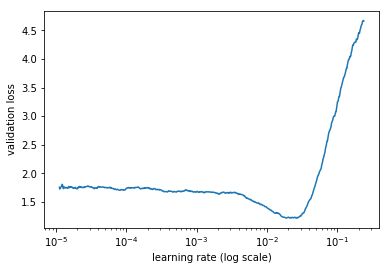

In [19]:
learn.sched.plot()

In [17]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                  
    0      0.818922   0.807252  
    1      0.786927   0.779639                                  
    2      0.615785   0.766221                                  



[array([0.76622])]

Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [21]:
math.sqrt(0.765)

0.8746427842267951

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

A interesting visulation using seaborne to plot

In [22]:
preds = learn.predict()

/home/wyquek/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/wyquek/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


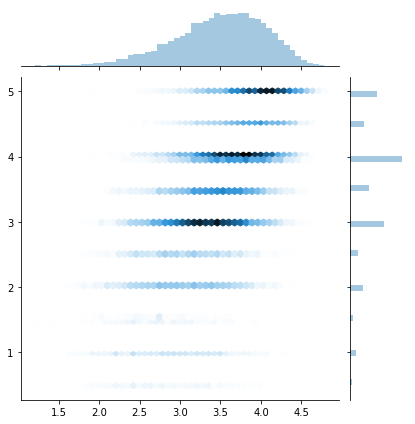

In [23]:
y=learn.data.val_y
# x-axis predictor top horizontal = hist(pred)
#y-axis= y value  right-hand vertical = hist(y)
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Analyze results

### Movie bias

In [18]:
movie_names = movies.set_index('movieId')['title'].to_dict(); movie_names

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (a.k.a. 12 Monkeys) (199

Movies that have the most number of user ratings

In [69]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values #[:3000]
topMovies
#[cf.item2idx[o] for o in topMovies][:10]

array([   356,    296,    318, ...,  26480,  26485, 163949])

In [70]:
[movie_names[i] for i in topMovies][-10:]

['Hair (1979)',
 'Luna, La (1979)',
 'Starting Over (1979)',
 'Bad Boys (1983)',
 'Blue Thunder (1983)',
 'Day After, The (1983)',
 'Eddie Murphy Delirious (1983)',
 'Raiders of Atlantis, The (1983)',
 'Rumble Fish (1983)',
 'The Beatles: Eight Days a Week - The Touring Years (2016)']

In [19]:
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])
topMovieIdx

array([  57,   49,   99, ...,  668, 4252, 4213])

To look at the model architecture, call `learn.models.model` or its shortcut `learn.model`

In [43]:
learn.model

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

In [47]:
m=learn.model

Note that if you want to put the model in cpu (e.g. to make a prediction after the model is trained) call m.cpu(). To put it back on gpu, call m.cuda()

In [59]:
m.cpu().ib(V(topMovieIdx).cpu()) 

Variable containing:
 0.8270
 0.9176
 1.2692
   ⋮    
 0.3153
-0.0025
 0.1652
[torch.FloatTensor of size 3000x1]

Now we put the m back on GPU

In [61]:
m.cuda()

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [45]:
topMovieIdx

array([  57,   49,   99, ...,  668, 4252, 4213])

Passing an array of movie indexes `topMovieIdx` through the bias Embedding `m.ib` will pull out the bias for each movie. This is like a look-up dictionary `(ib): Embedding(9066, 1)`.

In [62]:
movie_bias = to_np(m.ib(V(topMovieIdx)))

In [ ]:
def to_np(v):
    '''returns an np.array object given an input of np.array, list, tuple, torch variable or tensor.'''
    if isinstance(v, (np.ndarray, np.generic)): return v
    if isinstance(v, (list,tuple)): return [to_np(o) for o in v]
    if isinstance(v, Variable): v=v.data
    if isinstance(v, torch.cuda.HalfTensor): v=v.float()
    return v.cpu().numpy() # puts things on cpu and change to np

In [63]:
movie_bias

array([[ 0.82702],
       [ 0.91763],
       [ 1.26921],
       ...,
       [ 0.3153 ],
       [-0.00253],
       [ 0.16524]], dtype=float32)

In [64]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.  
Since movie_ratings is a tuple with 2 elements, we can sort it this way

In [66]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.9584071, 'Battlefield Earth (2000)'),
 (-0.7956044, 'Wild Wild West (1999)'),
 (-0.7594863, 'Speed 2: Cruise Control (1997)'),
 (-0.7262106, 'Anaconda (1997)'),
 (-0.7143692, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.640052, 'Super Mario Bros. (1993)'),
 (-0.63555425, 'Superman III (1983)'),
 (-0.62459457, 'Inspector Gadget (1999)'),
 (-0.6124194, 'Avengers, The (1998)'),
 (-0.6037861, 'Batman & Robin (1997)'),
 (-0.5988371, 'Little Nicky (2000)'),
 (-0.58628285, 'Honey, I Blew Up the Kid (1992)'),
 (-0.5764471, 'Karate Kid, Part III, The (1989)'),
 (-0.5733391, 'Congo (1995)'),
 (-0.57150364, 'Haunting, The (1999)')]

Jeremy claimed that 'Battlefield Earth' is the most movies of all times, but seems wrong. THese are the 3000 movies with the most number of ratings (proxy for high box office?), and this movie has the worest bias. So its actually the most watched but worstly rated movies of all times.

In [67]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.2692107, 'Shawshank Redemption, The (1994)'),
 (1.1591821, 'Godfather, The (1972)'),
 (1.0386945, 'Usual Suspects, The (1995)'),
 (0.95561165, '12 Angry Men (1957)'),
 (0.9503766, 'Godfather: Part II, The (1974)'),
 (0.917628, 'Pulp Fiction (1994)'),
 (0.88231146, 'Fargo (1996)'),
 (0.87726283, 'Silence of the Lambs, The (1991)'),
 (0.8702674, 'Matrix, The (1999)'),
 (0.8692416, 'To Kill a Mockingbird (1962)'),
 (0.8662901, 'Princess Bride, The (1987)'),
 (0.86249304, "Schindler's List (1993)"),
 (0.8615817, 'Rear Window (1954)'),
 (0.85153574, 'North by Northwest (1959)'),
 (0.8406066, 'Dark Knight, The (2008)')]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [95]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [96]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [97]:
movie_pca.shape

(3, 3000)

In [98]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [99]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.06356802, 'Cube (1997)'),
 (0.06247188, 'Gold Rush, The (1925)'),
 (0.053579386, 'Femme Nikita, La (Nikita) (1990)'),
 (0.05328588, 'I Love You, Man (2009)'),
 (0.051103517, 'October Sky (1999)'),
 (0.049606748, 'Harry Potter and the Chamber of Secrets (2002)'),
 (0.04945577, 'Scooby-Doo (2002)'),
 (0.049319476, 'Downfall (Untergang, Der) (2004)'),
 (0.04896426, '12 Years a Slave (2013)'),
 (0.048555806, 'Surrogates (2009)')]

In [100]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.057844568, 'Imaginarium of Doctor Parnassus, The (2009)'),
 (-0.05661865, 'Parent Trap, The (1998)'),
 (-0.05456287, 'Panic Room (2002)'),
 (-0.054223236, 'Lars and the Real Girl (2007)'),
 (-0.0537095, "Jesus' Son (1999)"),
 (-0.053356286, "Bill & Ted's Excellent Adventure (1989)"),
 (-0.053028107, 'Outbreak (1995)'),
 (-0.052619267, 'Animal House (1978)'),
 (-0.052410144, 'Avatar (2009)'),
 (-0.052295, 'Waiting for Guffman (1996)')]

In [101]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [102]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.05548163, 'Accused, The (1988)'),
 (0.054395366, 'Tears of the Sun (2003)'),
 (0.05285003, 'Dead Again (1991)'),
 (0.04942377, 'Dick Tracy (1990)'),
 (0.04925513, 'Benji (1974)'),
 (0.04886526, 'Love Actually (2003)'),
 (0.04791024, 'Along Came Polly (2004)'),
 (0.047210958, '50/50 (2011)'),
 (0.04552338, 'Help, The (2011)'),
 (0.045424614, 'Honey, I Shrunk the Kids (1989)')]

In [103]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.061750308, 'Touching the Void (2003)'),
 (-0.055197097, 'Cemetery Man (Dellamorte Dellamore) (1994)'),
 (-0.053384606, 'Kiss Kiss Bang Bang (2005)'),
 (-0.053169347, 'Slap Shot (1977)'),
 (-0.053100374, 'Blue Lagoon, The (1980)'),
 (-0.05299171, 'Blazing Saddles (1974)'),
 (-0.050142042, 'Elephant Man, The (1980)'),
 (-0.049057245, 'Big Trouble in Little China (1986)'),
 (-0.04688569, 'Ant-Man (2015)'),
 (-0.045081962, 'Bitter Moon (1992)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

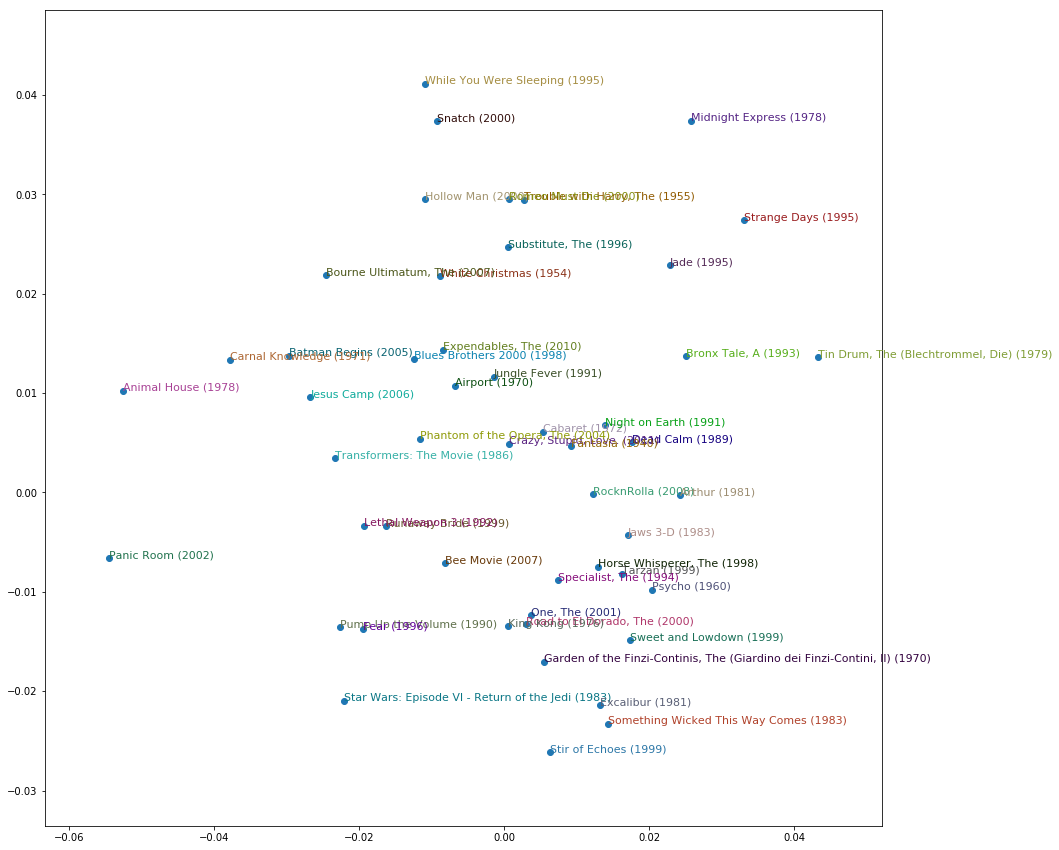

In [104]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example

In [8]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)], 
   2   2
  10  10
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)])

In [9]:
a*b


  2   4
 30  40
[torch.cuda.FloatTensor of size 2x2 (GPU 0)]

In [26]:
(a*b).sum(1)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

Create a very simple module

In [27]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [28]:
model=DotProduct()

In [29]:
model(a,b)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

In [ ]:
??nn.Module

### Dot product model

Build a layer or build a Pytorch Module

List the unique userID

In [30]:
ratings.userId.unique()[:20]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

Count the number of unique UserIDs

In [31]:
ratings.userId.nunique()

671

In [32]:
u_uniq = ratings.userId.unique()

Sometimes userID doesn't start from 0,1,2,3....but instead 1001,1005,1006,1100 etc.  
We have to make them contiguous. Map every unique userID to a contiguous integer

In [33]:
{o:i for i,o in enumerate(u_uniq[:10])}

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9}

Create the dictionary

In [34]:
user2idx = {o:i for i,o in enumerate(u_uniq)}

Replace old id with new id

In [35]:
ratings.userId[:30].apply(lambda x: user2idx[x])

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
Name: userId, dtype: int64

In [36]:
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

Do the same for movies

In [37]:
m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId.apply(lambda x: movie2idx[x])

0            0
1            1
2            2
3            3
4            4
5            5
6            6
7            7
8            8
9            9
10          10
11          11
12          12
13          13
14          14
15          15
16          16
17          17
18          18
19          19
20          20
21          21
22          22
23          23
24          24
25          25
26          26
27          27
28          28
29          29
          ... 
99974      473
99975      354
99976      355
99977     5577
99978      477
99979      478
99980      358
99981      479
99982      480
99983      359
99984     1225
99985     1240
99986      361
99987      126
99988     1260
99989      483
99990      362
99991      127
99992      364
99993     1299
99994      412
99995      486
99996     1308
99997      365
99998     2930
99999     7005
100000    4771
100001    1329
100002    1331
100003    2946
Name: movieId, Length: 100004, dtype: int64

In [38]:
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

In [39]:
int(ratings.userId.nunique())

671

In [40]:
n_users=int(ratings.userId.nunique())

In [41]:
int(ratings.movieId.nunique())

9066

In [42]:
n_movies=int(ratings.movieId.nunique())

## Create a more complex module

In [ ]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)  # create users embedding
        self.m = nn.Embedding(n_movies, n_factors) # create movie embedding
        self.u.weight.data.uniform_(0,0.05) # randomly initialize 
        self.m.weight.data.uniform_(0,0.05) # randomly initialize
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1)
    

In [31]:
???    
    @property
    def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

    @classmethod
    def add_bias(cls):
        
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
    

In [34]:
??nn.Embedding

In [36]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

Create panda dataframe in memory

In [ ]:
??ColumnarModelData.from_data_frame

In [ ]:
Signature: ColumnarModelData.from_data_frame(path, val_idxs, df, y, cat_flds, bs, 
                                             is_reg=True, is_multi=False, test_df=None, shuffle=True)
Docstring: <no docstring>
Source:   
    @classmethod
    def from_data_frame(cls, path, val_idxs, df, y, cat_flds, bs, is_reg=True, is_multi=False, 
                        test_df=None, shuffle=True):
        ((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idxs, df, y)
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, bs, 
                                    is_reg, is_multi, test_df=test_df, shuffle=shuffle)
File:      ~/Documents/Git/fastai/courses/dl1/fastai/column_data.py
Type:      method

from_data_frame(path, val_idxs, df, y, cat_flds, bs)

Next comes the data loader, which just load data into the learner at the rate of 64.  
x consists of two columns: `userID` and `movieId` are categorical variables. 
y is `rating`.

In [37]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

L2 regularization weight decay

In [47]:
wd=1e-5

Instantiate class `EmbeddingDot`

In [ ]:
model = EmbeddingDot(n_users, n_movies).cuda()

create the optimizer.  
model.parameters() is inherited from nn.Module. It automatically gives all the weights in the model to be updated (in this case the two pytorch *variables* `EmbeddingDot.u.weight` and `EmbeddingDot.m.weight`.

In [49]:
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [ ]:
??fit

fit is just the training loop,

Signature: fit(model, data, n_epochs, opt, crit, metrics=None, callbacks=None, stepper=<class 'fastai.model.Stepper'>, swa_model=None, swa_start=None, swa_eval_freq=None, **kwargs)
Source:   
def fit(model, data, n_epochs, opt, crit, metrics=None, callbacks=None, stepper=Stepper,
        swa_model=None, swa_start=None, swa_eval_freq=None, **kwargs):
    """ Fits a model

    Arguments:
       model (model): any pytorch module
           net = to_gpu(net)
       data (ModelData): see ModelData class and subclasses (can be a list)
       opts: an optimizer. Example: optim.Adam. 
       If n_epochs is a list, it needs to be the layer_optimizer to get the optimizer as it changes.
       n_epochs(int or list): number of epochs (or list of number of epochs)
       crit: loss function to optimize. Example: F.cross_entropy
    """

    seq_first = kwargs.pop('seq_first', False)
    all_val = kwargs.pop('all_val', False)
    get_ep_vals = kwargs.pop('get_ep_vals', False)
    metrics = metrics or []
    callbacks = callbacks or []
    avg_mom=0.98
    batch_num,avg_loss=0,0.
    for cb in callbacks: cb.on_train_begin()
    names = ["epoch", "trn_loss", "val_loss"] + [f.__name__ for f in metrics]
    if swa_model is not None:
        swa_names = ['swa_loss'] + [f'swa_{f.__name__}' for f in metrics]
        names += swa_names
        # will use this to call evaluate later
        swa_stepper = stepper(swa_model, None, crit, **kwargs)

    layout = "{!s:10} " * len(names)
    if not isinstance(n_epochs, Iterable): n_epochs=[n_epochs]
    if not isinstance(data, Iterable): data = [data]
    if len(data) == 1: data = data * len(n_epochs)
    for cb in callbacks: cb.on_phase_begin()
    model_stepper = stepper(model, opt.opt if hasattr(opt,'opt') else opt, crit, **kwargs)
    ep_vals = collections.OrderedDict()
    tot_epochs = int(np.ceil(np.array(n_epochs).sum()))
    cnt_phases = np.array([ep * len(dat.trn_dl) for (ep,dat) in zip(n_epochs,data)]).cumsum()
    phase = 0
    for epoch in tnrange(tot_epochs, desc='Epoch'): # For these epochs 
        if phase >= len(n_epochs): break #Sometimes cumulated errors make this append.
        model_stepper.reset(True)
        cur_data = data[phase]
        if hasattr(cur_data, 'trn_sampler'): cur_data.trn_sampler.set_epoch(epoch)
        if hasattr(cur_data, 'val_sampler'): cur_data.val_sampler.set_epoch(epoch)
        num_batch = len(cur_data.trn_dl)
        t = tqdm(iter(cur_data.trn_dl), leave=False, total=num_batch, miniters=0)
        if all_val: val_iter = IterBatch(cur_data.val_dl)

        for (*x,y) in t: #Q For x and y in training data loader
            batch_num += 1
            for cb in callbacks: cb.on_batch_begin()
            loss = model_stepper.step(V(x),V(y), epoch) #Q calculate the loss
            avg_loss = avg_loss * avg_mom + loss * (1-avg_mom)
            debias_loss = avg_loss / (1 - avg_mom**batch_num)
            t.set_postfix(loss=debias_loss, refresh=False) #Q print out the loss in progress bar
            stop=False
            los = debias_loss if not all_val else [debias_loss] + validate_next(model_stepper,metrics, val_iter)
            for cb in callbacks: stop = stop or cb.on_batch_end(los)
            if stop: return
            if batch_num >= cnt_phases[phase]:
                for cb in callbacks: cb.on_phase_end()
                phase += 1
                if phase >= len(n_epochs):
                    t.close()
                    break
                for cb in callbacks: cb.on_phase_begin()
                if isinstance(opt, LayerOptimizer): model_stepper.opt = opt.opt
                if cur_data != data[phase]:
                    t.close()
                    break

        if not all_val:
            vals = validate(model_stepper, cur_data.val_dl, metrics, seq_first=seq_first) #Q call metric on valid
            stop=False
            for cb in callbacks: stop = stop or cb.on_epoch_end(vals)
            if swa_model is not None:
                if (epoch + 1) >= swa_start and ((epoch + 1 - swa_start) % swa_eval_freq == 0 or epoch == tot_epochs - 1):
                    fix_batchnorm(swa_model, cur_data.trn_dl)
                    swa_vals = validate(swa_stepper, cur_data.val_dl, metrics)
                    vals += swa_vals

            if epoch == 0: print(layout.format(*names))
            print_stats(epoch, [debias_loss] + vals)
            ep_vals = append_stats(ep_vals, epoch, [debias_loss] + vals)
        if stop: break
    for cb in callbacks: cb.on_train_end()
    if get_ep_vals: return vals, ep_vals
    else: return vals
File:      ~/Documents/Git/fastai/courses/dl1/fastai/model.py
Type:      function


Note that no fastai learner was used. Just the pytorch module `EmbeddingDo` and `fit`, although both found in fastai, are much lower level and takes in regular pytorch model

In [50]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                 
    0      1.651911   1.641445  
    1      1.098256   1.302979                                 
    2      0.933108   1.227365                                  



[array([1.22737])]

Note that fastai learner attained 0.76, way better than 1.222 in this DIY model. Tha's because the former has SGDRestart and learning rate annealing and other stuffs built into it. Let's try to do better.

Let's add learning rate annealing. Passed in a standard pytorch optimizer `opt` and the new learning rate 0.01.  
This is effectively **'manual'** annealing.

In [40]:
??set_lrs

In [51]:
set_lrs(opt, 0.01)

In [52]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.691295   1.144963  
    1      0.697526   1.133717                                  
    2      0.692301   1.127552                                  



[array([1.12755])]

Slight improvement to 1.13.

### Bias

Some users are just more enthuastic about movies and rate them higher, while some movies are just more popular, like Hollywood blockbuster.  
So there should be a bias added to account for these.

Get the min and max ratings for squishing the sigmoid function later.

In [53]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

Create a simple embedding `get_emb(ni,nf)`

In [54]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

Use it to create 4 embedding matrices of different sizes, u,m,ub,mb.   
This time the biases are created using   
(n_users,1) and  
(n_movies,1)

In [55]:
[get_emb(*o) for o in [(n_users, n_factors), 
                       (n_movies, n_factors), 
                       (n_users,1), 
                       (n_movies,1)]]

[Embedding(671, 50),
 Embedding(9066, 50),
 Embedding(671, 1),
 Embedding(9066, 1)]

pytorch squeeze()

In [ ]:
t = torch.ones(2,1,2,1) # Size 2x1x2x1
r = torch.squeeze(t)     # Size 2x2
r1 = torch.squeeze(t, 1)  # Squeeze dimension 1: Size 2x2x1

`um + self.ub(users).squeeze() + self.mb(movies).squeeze() ` means the 2 bias is broadcasted to the dot.product `um`   
(number of times = 64 = batch size)

`F.` is pytorch.nn.Functional contains the activation functional modules such as sigmoid, relu, and also dropouts and loss functions such as mse.  
`F.sigmoid(res) * (max_rating-min_rating) + min_rating` squishes the ratings between 1-5.  
**res = F.sigmoid(res) * (max_rating-min_rating) + min_rating** is actually optional, as the NN will still learn eventually that the ratings are 1-5, albeit slowly. Making it explicit in this manner quickens the learning.

In [49]:
class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1) # usual dot product        
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze() # here added the biases
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res

Run the same DIY model. `.cuda()` has to be called so that it is run in the GPU. in `learner` this is automatically done.

In [ ]:
wd=2e-4 #l2 regularization
#model = 
EmbeddingDotBias(cf.n_users, cf.n_items).cuda() 
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [58]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.837298   0.837997  
    1      0.800115   0.817285                                  
    2      0.825385   0.806785                                  



[array([0.80678])]

Pretty good number for DIY model.  
Perform **'manual'** lr annealing.

In [59]:
set_lrs(opt, 1e-2)

In [60]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.747505   0.802222  
    1      0.782201   0.800711                                  
    2      0.758882   0.800307                                  



[array([0.80031])]

Very close to fastai learner's performance. learner performed better due to SGDR, cycle multiplier and ADAM optimizer.

Next we create a deep learning version of collaborative filtering.

### Mini net

Concatenate the userID embedding vector and movieID embedding vector together as input, which is then fed into a NN by doing this: `torch.cat([self.u(users),self.m(movies)`  
It is joined by columns, hence dim = 1 or axis 1 as the embedding matrix are of shape (n_movies, n_factors).  
  
Note that `userID embedding vector` and `movieID embedding vector` no longer needs to be the same size as they were in collaborative filtering. Now that they are in a neural-net, the two can be of different embedding size.  

`nn.Linear(n_factors*2, nh)` creates a hidden layer with size  
twice the embedding vector `n_factors*2` AND the number of hidden nodes `nh`  
It is later put into a RELU using `F.relu(self.lin1(x))`  

`nn.Linear(nh, 1)` is the last layer with a single output, as we want to predict a single rating. It is later put in a sigmoid using `F.sigmoid(self.lin2(x))`

In [61]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        #  create th embeddings
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        # create the 2 dense layer
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        # concat the 2 embedding vectors by column (axis 1)
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [62]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [63]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.935745   0.826266  
    1      0.817079   0.797127                                  
    2      0.800073   0.789632                                  



[array([0.78963])]

In [64]:
set_lrs(opt, 1e-3)

In [65]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.777137   0.790877  
    1      0.790171   0.792207                                  
    2      0.761778   0.794079                                  



[array([0.79408])]